In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import sys
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# ml
sys.path.append('..')
import decisiveml as dml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Assume CL futures margin
margin = 5000

start_date = datetime.date(2016, 1, 1)
end_date = datetime.date(2018, 1, 1)

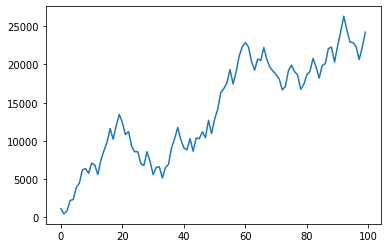

In [19]:
# We're going to generate a random list of trades,
# and you should replace this with your walkforward list of trades
trades_list = random.sample(range(-2000, 2300), 100)
cumsum = np.asarray(trades_list).cumsum()
plt.plot(cumsum)

In [20]:
# Initialize
mc = dml.MonteCarlo(trades_list)

# We will sample with replacement the number of trades per year
# so we need the start and end date to determine how many trades at in a year on average
mc.settings(margin, start_date, end_date)

# Test different levels of equity starting at this value
trial_starting_equity = int(margin * 1.5)

# Run the Monte Carlo
results = mc.run(trial_starting_equity)

In [30]:
# Put the results in a dataframe so it's nicer to look at in notebook
# Our goal is to get the highest equity below 10% Risk of Ruin
df = pd.DataFrame(index=range(1,len(results)))
count = 1
for index, result in results.iterrows():
    df.loc[count, 'equity'] = result['equity']
    df.loc[count, 'is_ruined'] = result['is_ruined']
    df.loc[count, 'is_profitable'] = result['is_profitable']
    df.loc[count, 'returns_pct'] = result['returns_pct']
    df.loc[count, 'drawdown_pct'] = result['drawdown_pct']
    df.loc[count, 'returns_per_drawdown'] = result['returns_per_drawdown']
    count += 1

# Get the recommended values
recommended = df[df['is_ruined'] <= 10].iloc[0]
print('Recommend a starting equity of {}, which has {:0.2}% Risk-of-Ruin, \n\t{:0.0f}% Probability-of-Profit and a {:0.2f} Returns/Drawdown Ratio'.format(
                recommended['equity'], recommended['is_ruined'], 
                recommended['is_profitable'], recommended['returns_per_drawdown']))

if recommended['is_ruined'] > 10 or recommended['returns_per_drawdown'] < 2.0:
    print("Risk Assessment: FAILED")
else:
    print("Risk Assessment: PASSED")

mc_1p5x = recommended['drawdown_pct'] * 1.5
print("MC-Drawdown: {:0.1f}% MC-1.5x-DD: {:0.1f}%".format(recommended['drawdown_pct'], mc_1p5x))

profit = recommended['equity'] * recommended['returns_pct'] / 100
months = (end_date - start_date).days/30
average_monthly_net_profit = profit / months
print("Average monthly net profit: {:0.1f}".format(average_monthly_net_profit))

Recommend a starting equity of 13125.0, which has 6.8% Risk-of-Ruin, 
	90% Probability-of-Profit and a 2.93 Returns/Drawdown Ratio
Risk Assessment: PASSED
MC-Drawdown: 29.9% MC-1.5x-DD: 44.9%
Average monthly net profit: 474.0


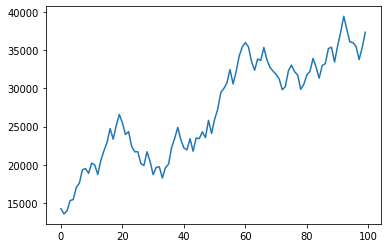

In [31]:
plt.plot(cumsum + recommended['equity'])

# Build a plot out of the recommendation

In [32]:
simulation_equity = pd.Series(recommended['equity'] + cumsum)

In [33]:
target_equity = recommended['equity'] + pd.Series([average_monthly_net_profit] * len(simulation_equity)).cumsum()

In [34]:
mc_x15_drawdown = recommended['drawdown_pct'] * 1.5

In [35]:
decrease_by_pct = ((100-mc_x15_drawdown)/100)

In [36]:
dollar_x15_drawdown = decrease_by_pct * average_monthly_net_profit

In [37]:
min_equity = recommended['equity'] + pd.Series([dollar_x15_drawdown] * len(simulation_equity)).cumsum()

In [38]:
mdd15 = simulation_equity.cummax() * decrease_by_pct

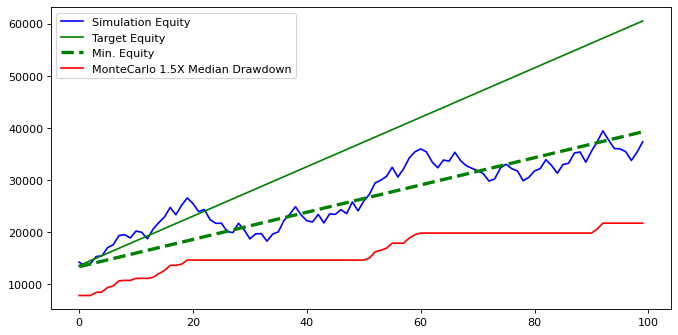

In [42]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(simulation_equity, color='blue', label='Simulation Equity')
plt.plot(target_equity, color='green', label='Target Equity')
plt.plot(min_equity, color='green', linestyle='--', linewidth=3, label='Min. Equity')
plt.plot(mdd15, color='red', label='MonteCarlo 1.5X Median Drawdown')
plt.legend(loc="upper left")